In [1]:
# We import some helpful stuff
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

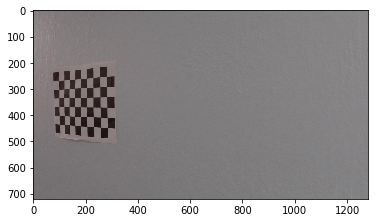

In [2]:
# We read in and display a calibration image
img = cv2.imread('camera_cal/calibration11.jpg')
plt.imshow(img)

In [3]:
# We create an array to hold the 2D image points of our calibration image
# and one to hold the 3D object points of the real world object (that is, the chessboard)
imgpoints = []
objpoints = []

In [4]:
# We ask np.zeros for a 6x9 matrix that has 3 points at every point (for x, y, & z)
# Yet z is = 0 at every point of the real world object
# Thus, we prepare object points thusly: (0,0,0), (1,0,0), (2,0,0)... (8,5,0)
objp = np.zeros((6*9, 3), np.float32)
# We then use np.mgrid to generate coordinates
# for the first two columns of objp (that is, x and y)
# for our grid of size 9, 6 and then shape them into
# a matrix of two columns
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [5]:
# To procure the image points, we use cv2.findChessboardCorners()
# on our 9 x 6 chessboard image (None refers to any flags)
# after moving the image to the Grayscale color space
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

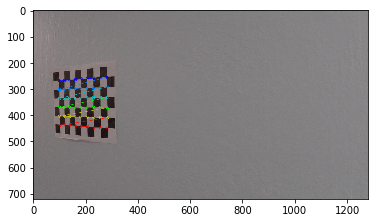

In [6]:
# If corners are found...
if ret == True:
    # append them to the image point array
    imgpoints.append(corners)
    # and append objp (created above) to the object point array
    objpoints.append(objp)
    # (Note: because objp is the ideal reference,
    # it will be compared to all of our calibration images)
    
    # Then draw the corners on our original, non-grayscale img
    # and display the image
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    plt.imshow(img)

In [7]:
# So, there's an interesting-ish thing going on...
#
# It seems drawChessboardCorners() is very sensitive
# to the size of matrix one is looking for.
# If the user doesn't specify precisely the matrix
# size that the function is able to locate in gray, it returns None for corners
# (No wonder checking if ret == True is the logic token of choice here)
#
# For example, with calibration6.jpg, it only works if I specify a (9,6) matrix,
# whereas for calibration5.jpg, the system demands a matrix of size (7,6) to work.
#
# I guess I could just quickly try all options in the 9x6 range...
# But I'd really rather just hardcode a working solution.
#
# There's a further issue: which is that the calibration images
# that Udacity has provided me with can qualitatively be divided into two groups: 
# calibration1 - calibration5 are very different from calibration6 - calibration20
# not only aesthetically / visually, but also in regards to proximity to the chessboard;
# the latter group doesn't crop any of the edges in the way the former group does.
#
# And since I've just decided I'm lazy enough to want a hardcoded option
# I may be effectively cutting myself off from 1/4th of the data.
# This concerns me, as Cezanne said we wanted a minimum of 20 calibration images, ideally...
#
# Update: while checking the OpenCV docs for calibrateCamera(), I came across this statement: 
# "For better results, we need at least 10 test patterns." 
# So, it seems we're good with just 14 images (6 - 20)...
#

In [8]:
# So, we read in all the calibration images via the glob API, which we import
import glob

images = glob.glob('camera_cal/calibration*.jpg')
# Note: we are only able to use the wildcard * above because we have already
# removed calibration1.jpg - calibration5.jpg from the camera_cal folder

In [9]:
# This time around, let's make our chessboard dimension sizes into variables
board_x = 9
board_y = 6

In [10]:
# And let's redo the creation of imgpoints, objpoints, and objp
# just to be sure our results work with the new settings variables...
imgpoints = []
objpoints = []
objp = np.zeros((board_y*board_x, 3), np.float32)
objp[:,:2] = np.mgrid[0:board_x,0:board_y].T.reshape(-1,2)

In [11]:
# Then we iterate through the images, and apply the process developed above
for fname in images:
    # Read in image
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If corners are found...
    if ret == True:
        # append them to the image point array
        imgpoints.append(corners)
        # and append objp (created above) to the object point array
        objpoints.append(objp)
        # (Note: because objp is the ideal reference,
        # it will be compared to all of our calibration images)    

In [12]:
# With all our sets of calibration image points, and identical sets of ideal object points,
# we are ready to feed them into cv2.calibrateCamera()
# Note: mtx is our (3D -> 2D) Camera matrix, and dist our distortion coefficients
# both of which we need to transform 3D object points to 2D image points.
# rvecs and tvecs are the rotation and translation vectors that describe the camera's
# location in the world, which calibrateCamera also returns.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)


In [13]:
# We now go about applying cv2.undistort() with our long-sought mtx and dist.
# We start testing by applying it to one of our calibration images, 
# which we first load and display:

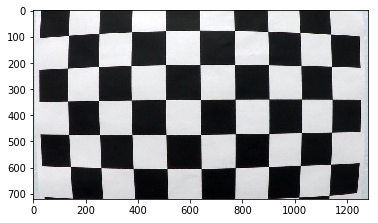

In [14]:
img = cv2.imread('camera_cal_unused/calibration1.jpg')
plt.imshow(img)

In [15]:
# And now, the same image undistorted:

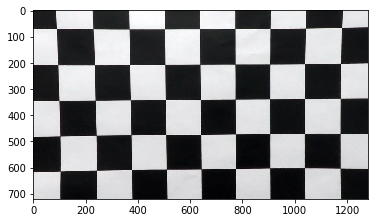

In [16]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [17]:
# Looks pretty good to my eye!
# Let's apply it to the actual test_image.png provided,
# loaded and displayed here:

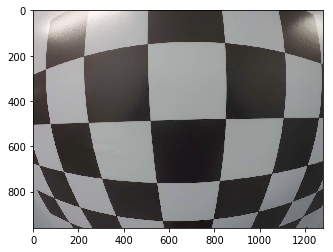

In [18]:
img = cv2.imread('camera_cal/test_image.png')
plt.imshow(img)

In [19]:
# And now with our Camera matrix and distortion coefficients 
# applied via undistort():

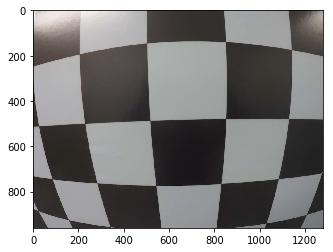

In [20]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [21]:
# One's first reaction at seeing this undistorted version of 
# test_image.png is naturally disappointment, as it is much less of 
# a dramatic and obvious correction as compared to the first 
# test image above.
#
# "Does my pipeline not actually work?" I wondered.
#
# But then I realized, "It may have worked, it's just that 
# there's perhaps even more distortion beyond what our numbers 
# can correct for, due to the way the chessboard was photographed 
# most likely (viz. with even greater proximity.)"
#
# Which, of course, made me think about the mysterious 
# fifth distortion co-efficient k_3! 
# Could that be what's needed here, to really 
# straighten out this situation?!  : )
#
# Or, wait... maybe k_3 is already in the mix here,
# and it's just back to my original point: there are effects of 
# this camera / this shoot that are essentially overwhelming
# the undist() algorithm (fed with our numbers), even though
# it *is* actually working, and as expected...
#
# In any case, I have no desire to chase this down right now.
# My pipeline is obviously working on my given test set,
# so I'm moving on, happily... ; )

In [22]:
# Let's move on to creating a stacked combination of 
# binary thresholding the S (Saturation) channel of the HLS color space and
# binary thresholding the result of applying the Sobel operator in the x direction
# on the original image, as shown in Lesson 17, sub-Lesson 12: Color and Gradient
# (Note: all of the code, as well as the general approach - that is, the combination
# of this particular color channel and gradient process - in this part of the pipeline
# is cribbed directly from the aforementioned sub-Lesson.)

In [23]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

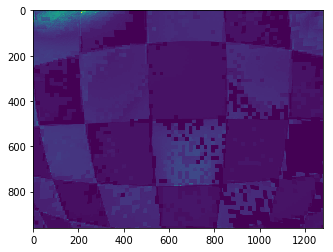

In [24]:
# Let's take a peek at our Saturation channel image...
plt.imshow(s_channel)

In [25]:
# Grayscale the image
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

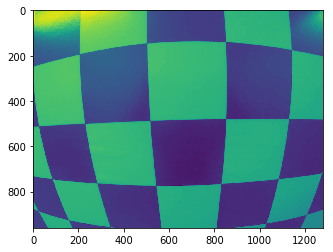

In [26]:
# Check our work
plt.imshow(gray)

In [27]:
# The directions at this point include this note:
#
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
#
# I must admit I'm not totally clear on why we are grayscaling the image
# if the Instructor thinks the fact that doing so removes color information
# is a problem to be solved here. In any case...

In [28]:
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

In [29]:
# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

In [30]:
# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

In [31]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

In [32]:
# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

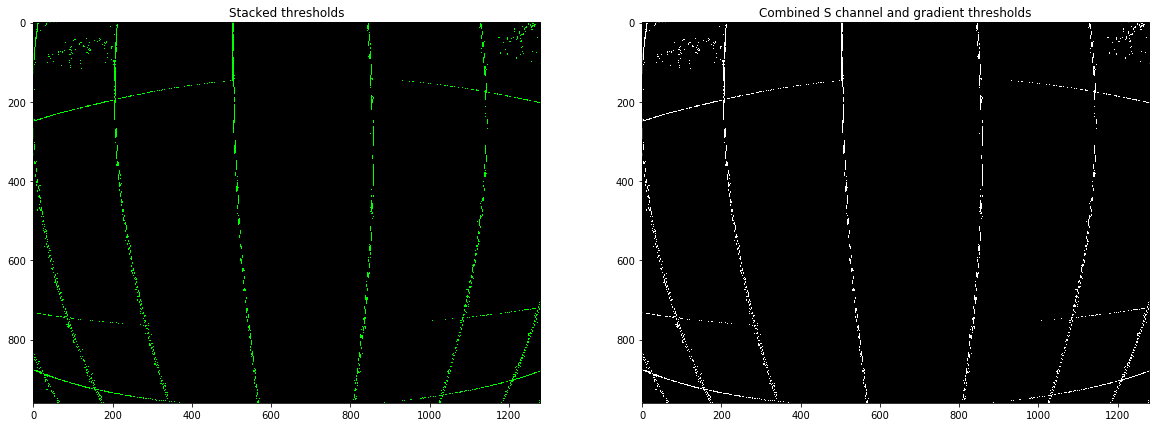

In [33]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

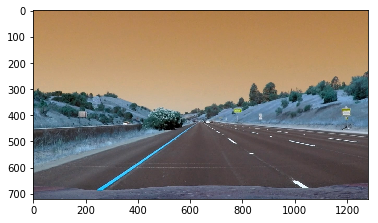

In [34]:
# Cool stuff!  : )

# Let's repeat the above process with a road image
img = cv2.imread('test_images/straight_lines1.jpg')
plt.imshow(img)

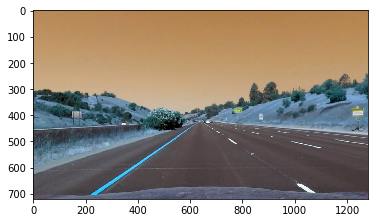

In [35]:
# Undistort it
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

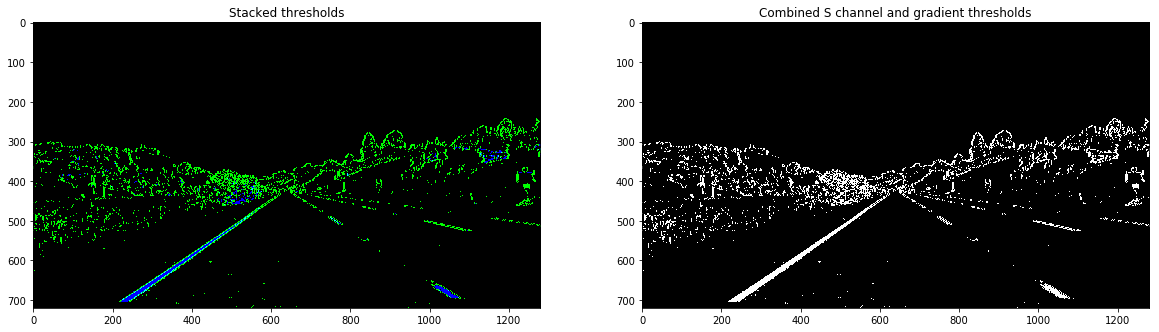

In [36]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

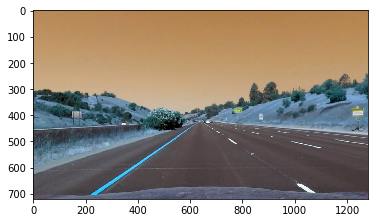

In [37]:
# Coooool...  : D

# To begin our Perspective Transform process, we will be manually selecting 4 points from
# our straight_lines1.jpg test image. In sub-Lesson 16: Transform a Stop Sign, the Instructor
# uses %matplotlib qt in order to open the image in another window, which allows them to inspect 
# the x,y attributes of every pixel in the image via the cursor pointer. 
# (It should be noted that the carnd-term1 environment has to have its version of matplotlib upgraded 
# in order for this option to be available.)
%matplotlib qt
plt.imshow(undist)

In [38]:
# Using the above method, we have picked out the following source points
src = np.float32([[232, 710], [588, 461], [699, 461], [1062, 699]])
# And check our work
print(src)

[[ 232.  710.]
 [ 588.  461.]
 [ 699.  461.]
 [1062.  699.]]


In [39]:
# As our Instructor says, we can "define our desired rectangle plane for the warped image
# and... choose four different points that are where [we] want the source points to end up...
# by just eyeballing a rectangle in that same image" of ours. I thereby select the following
# destination points:
dst = np.float32([[232, 710], [232, 461], [1062, 461], [1062, 699]])

# Note: unlike the Instructor, I keep my first and last Source points as Destination points verbatim.

# And check our work:
print(dst)

[[ 232.  710.]
 [ 232.  461.]
 [1062.  461.]
 [1062.  699.]]


In [40]:
# Now we can compute the perspective transform, M, given our source and destination points:
M = cv2.getPerspectiveTransform(src, dst)

# And one more work check
print(M)

[[-6.70553612e-01 -1.48563733e+00  1.05937039e+03]
 [-1.41446402e-02 -1.71814184e+00  7.61048508e+02]
 [-3.06825167e-05 -2.31513535e-03  1.00000000e+00]]


In [41]:
# We need to grab our image size real quick before using warpPerspective()
img_size = (undist.shape[1], undist.shape[0])

print(img_size)

(1280, 720)


In [42]:
# Lastly, we warp an image using the perspective transform, M:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

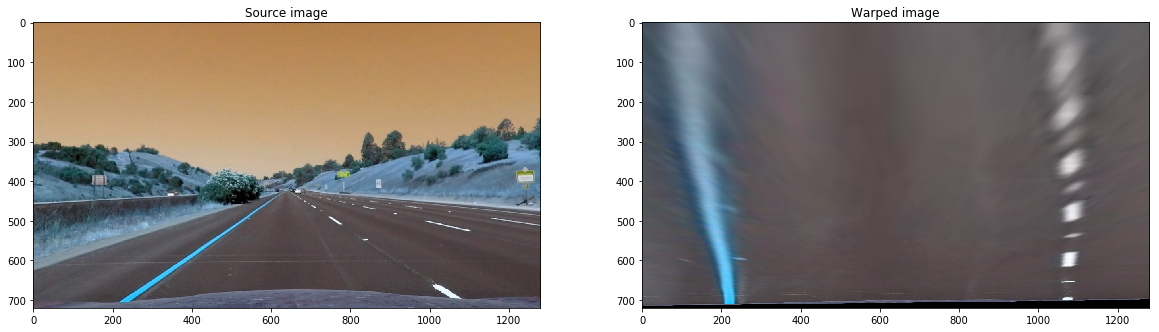

In [43]:
# Let's jump back to inline presentation
%matplotlib inline

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [44]:
# Wow, those Warped image lane lines are not very straight / parallel...
# Hmm... Maybe the lanes / lane lines in the Source image aren't as straight as they seem to be...
# Or maybe there's a reason the Instructor didn't keep any of their original points verbatim...

# Let me try a different set of Source & Destination points 
# and hence a different M matrix...
src = np.float32([[220, 720], [610, 443], [673, 443], [1090, 720]])
dst = np.float32([[220, 720], [220, 443], [1090, 443], [1090, 720]])
M = cv2.getPerspectiveTransform(src, dst)

# And rewarp the image
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

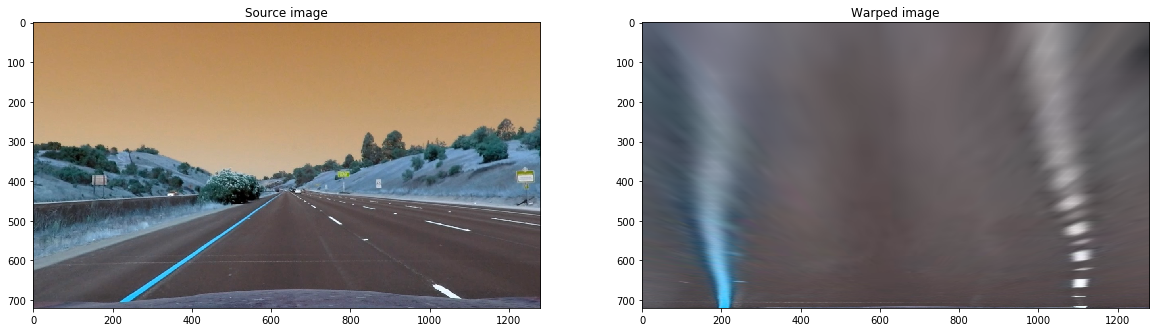

In [45]:
# And let's look at our work again
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [46]:
# Hmm... not much better.  : /
# 
# (So... sidenote on process: Because the Instructor did not keep any of her Source points
# in her Destination points, I began to take that as some sort of a hint for how I could get
# straighter / more parallel lane lines in my Warped image. However, this massaging parameters
# to produce a more preferential outcome didn't / doesn't sit well with me. Thus, I went back and 
# re-picked the src and dst points, and decided to trust the math more...
#
# And in looking at the Source image again, it is quite clear that - although the lane lines
# in our image are more or less straight - the lane our car is in eventually curves to the
# left. Thus, it is perhaps unsurprising that our Warped image tends slightly to the left, and 
# is in fact perhaps justification for the correctness of our method.
#
# In any case, as mentioned in 18.2: Processing Each Image, "When applying the transform to new images, 
# the test of whether or not you got the transform correct, is that the lane lines should appear parallel 
# in the warped images, whether they are straight or curved," which is more or less the case here...
#
# TODO: apply the above process to the other straight lines image - straight_lines2.jpg?)
#
# For now, let's just apply the above warpPerspective to a test image with more obviously
# curved lane lines...

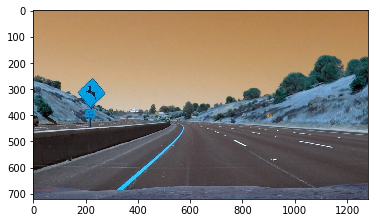

In [47]:
img = cv2.imread('test_images/test2.jpg')
plt.imshow(img)

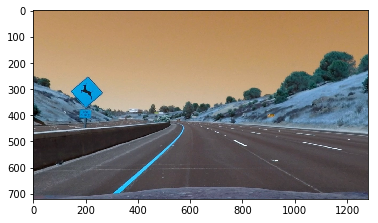

In [48]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [49]:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

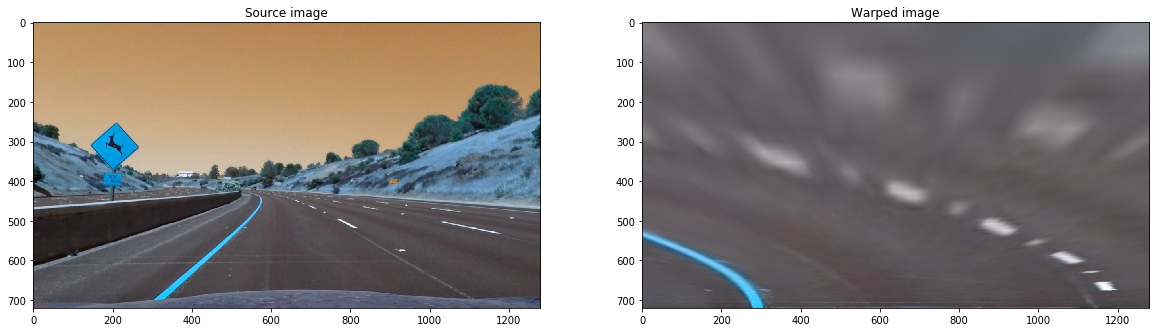

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [51]:
# Lol... I mean, I guess it could be worse?...
# And it still seems like the lane lines are more or less parallel...
#
# I'm starting to suspect that our revised points are too ambitious;
# which is to say, I feel like the rectangle we are finagling is too large,
# such that it's having too extreme of a warping effect. Thus, I'm going to 
# try again using our previous measurements and resultant M
#
# WAIT A MINUTE. Hold the phone. In looking at the assets in 18.2, I noticed
# that the Instructor's ideal rectangle is as tall as the original image,
# whereas I had been capping mine at the height of the rectangle I picked
# out of the Source image.
#
# This also explains why the upper sections of my Warped lane lines
# were so fuzzed out compared to the Instructor's results.
#
# I'm going to go back one more time and re-calculate these values:

src = np.float32([[220, 720], [610, 443], [673, 443], [1090, 720]])
dst = np.float32([[220, 720], [220, 0], [1090, 0], [1090, 720]])
M = cv2.getPerspectiveTransform(src, dst)

In [52]:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

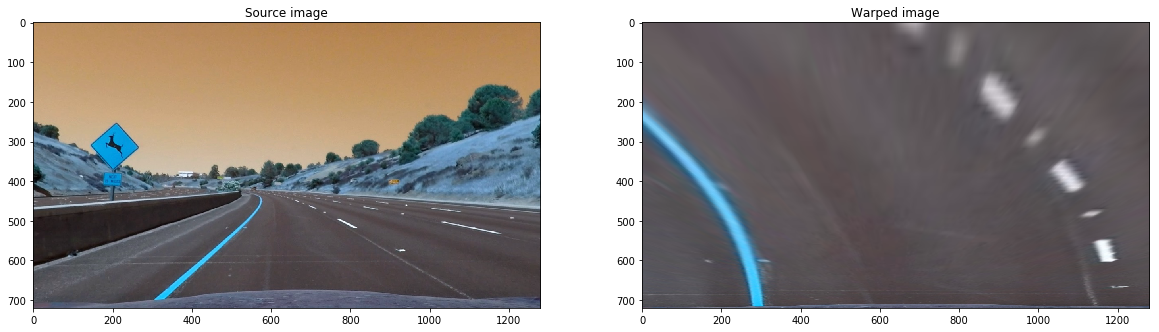

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

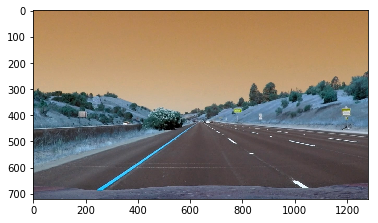

In [54]:
# Ah, that's so much better...
#
# Let me apply this to straight_lines1.jpg just so I can feel better about everything.
img = cv2.imread('test_images/straight_lines1.jpg')
plt.imshow(img)

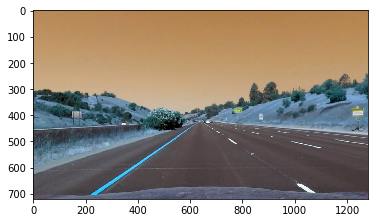

In [55]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

In [56]:
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

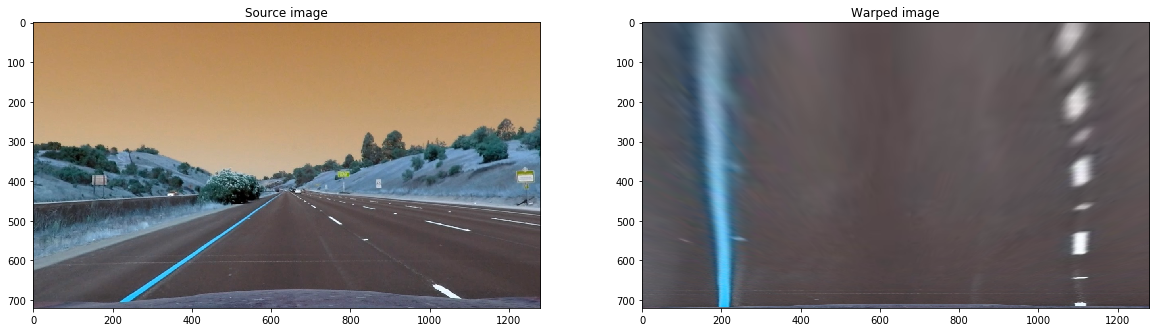

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(undist)
ax2.set_title('Warped image')
ax2.imshow(warped)

In [58]:
# Oh my god, that's so much better!!  : )
# (And still trending to the left, it's worth noting / noticing... ; )
#
# Moving on: For a moment there, I mistakenly thought it might not matter whether or not
# we do the thresholding / binary combining before or after the perspective
# transform, but now I see that it does (probably?) create a very different
# end product... Why am I stating a hypothesis when I could just compare both versions? : )

In [59]:
def make_binary(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

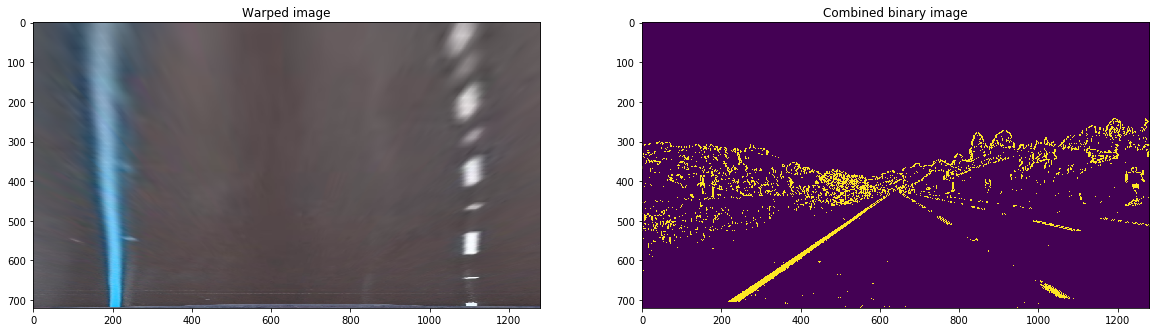

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Warped image')
ax1.imshow(warped)
ax2.set_title('Combined binary image')
ax2.imshow(combined_binary)

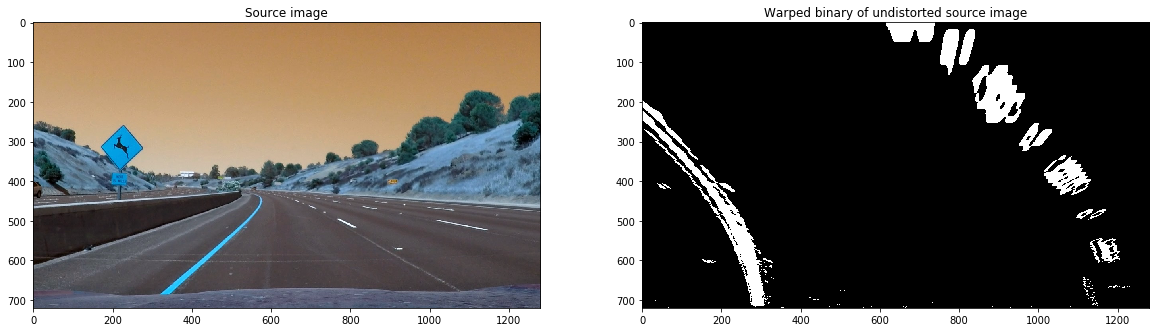

In [102]:
# Oh, yes; of course. We can see right away that the reason why we can't create
# our combined thresholded binaries after Perspective Transform is because the 
# Saturation level of the lane lines is "diluted" by the effects of the PT 
# blurring things that are farther away, such that they drop out of the S channel entirely...
# Thus, no need to continue with the comparison; Binary Creation must happen before Perspective Transform.
#
# Let's start from the top:

# Load image
img = cv2.imread('test_images/test2.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

In [103]:
# Ah, yes. Those are much better results... : )  We have the preprocessing part of our pipeline done.
#
# Following the process laid out by our Instructors, we next find the histogram in our image:

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

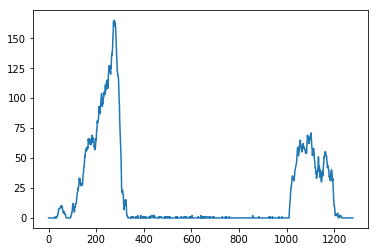

In [104]:
# Create histogram of image binary activations
histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

In [105]:
# As the instructions say, "we can use the two highest peaks from our histogram 
# as a starting point for determining where the lane lines are, and then use 
# sliding windows moving upward in the image (further along the road) to determine 
# where the lane lines go.
#
# The first step we'll take is to split the histogram into two sides, one for each lane line."

# (But before that, the 0th step is to:)
# Create an output image to draw on and visualize the result
out_img = np.dstack((warped, warped, warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [106]:
# "Our next step is to set a few hyperparameters related to our sliding windows, 
# and set them up to iterate across the binary activations in the image."
#
# Again: all of the following is cribbed directly from our Instructors.

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [107]:
# At this point, our Instructors are just checking our copy & paste skills, ha..
#
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
    (win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
    (win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices (previously was a list of lists of pixels)
try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [108]:
# Our instructors put everything from the histogram creation up to this point
# into the function 

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [109]:
# Then they fit the polynomial:

def fit_polynomial(warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

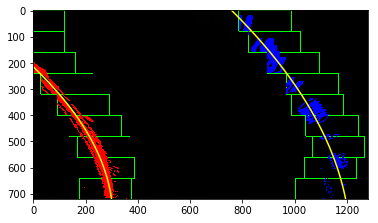

In [110]:
# And, let's take a little look-see

out_img = fit_polynomial(warped)

plt.imshow(out_img)

In [100]:
# Siiick! *smiling sunglasses emoji*
#
# We now recreate the above with a more efficient method that searches
# "in a margin around the previous line position"

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print (left_fit)
    print (right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

[ 7.75823303e-04 -8.50878052e-01  4.33192041e+02]
[-1.34831324e-05 -5.67095462e-02  1.15725312e+03]


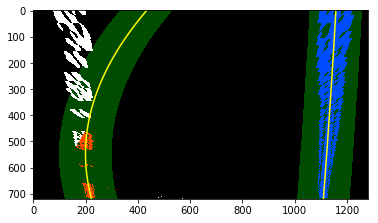

In [101]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

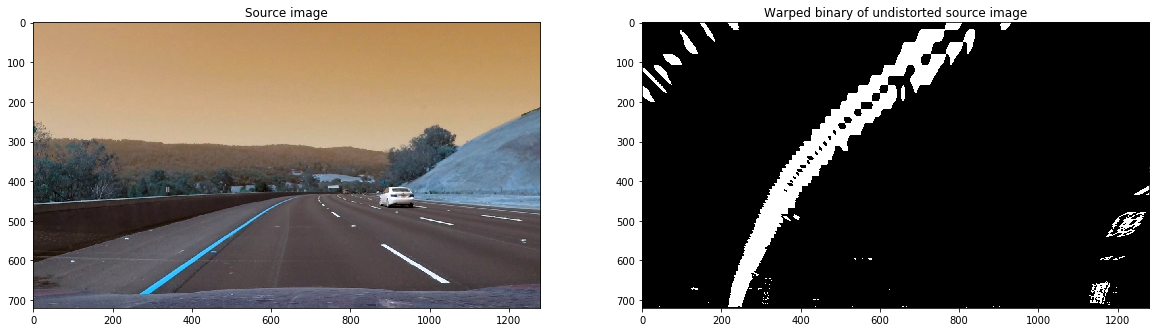

In [89]:
# Hm... Looking pretty okay on the right, not so much on the left. 
# That might be due to the hard coded nature of our "previous" data...
# Gonna try again with a different test image.

# Load image
img = cv2.imread('test_images/test3.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

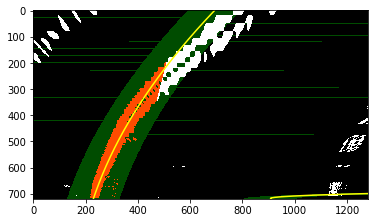

In [90]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

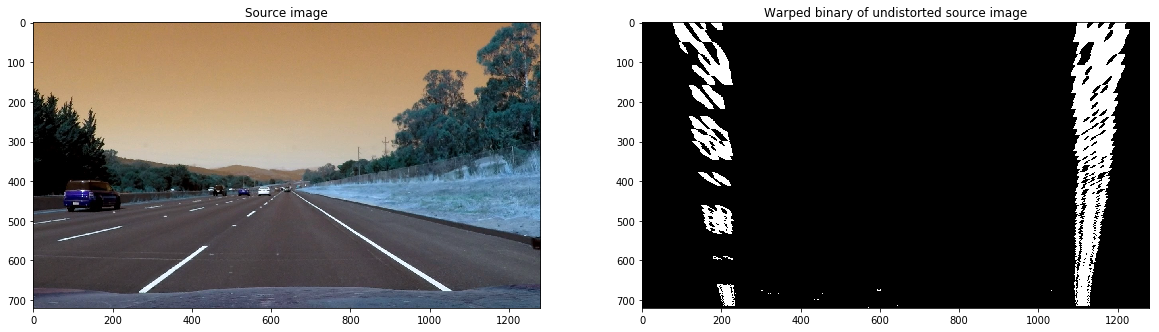

In [93]:
# Huh, not great...
#
# I'm still pretty convinced that this will improve once we create 
# an actual live pipeline that is generating real data.
#
# Let me try another one, just for fun

# Load image
img = cv2.imread('test_images/straight_lines2.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

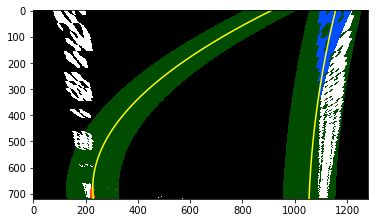

In [94]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

In [116]:
# Hahaha!...
#
# Y'know what? I'm gonna re-run the above with data taken from the image itself.
# Perhaps this will give better results

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!

# NOTE: Just to reiterate, the below values were / are found by running
# fit_poly() in order to trigger the two print statements to spit out
# the coefficients of the current picture, which we then hardcode into the
# below assignment statements so that we can be assured that the "previous"
# data we're fitting in are more or less within the realm of reasonability...

left_fit = np.array([7.75823303e-04, -8.50878052e-01, 4.33192041e+02])
right_fit = np.array([-1.34831324e-05, -5.67095462e-02, 1.15725312e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print (left_fit)
    print (right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

[-9.46163864e-04  1.45293443e+00 -2.64104863e+02]
[-1.29039153e-03  1.64959204e+00  6.33421560e+02]


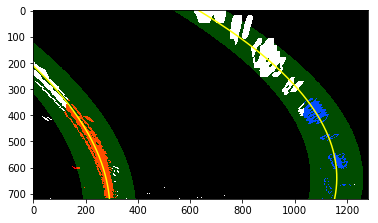

In [117]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

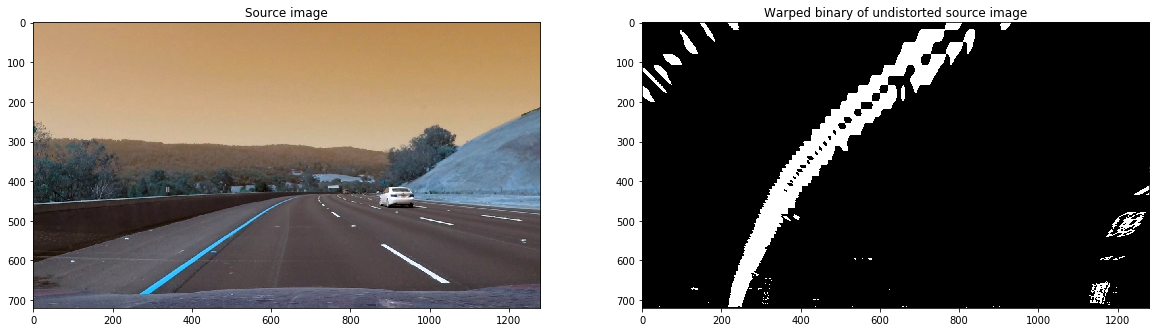

In [120]:
# Oh, wow; finally, some nice results... I needed that
#
# Gonna run it on one or two more, just to build confidence

# Load image
img = cv2.imread('test_images/test3.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

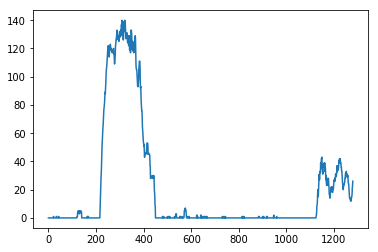

In [121]:
# Create histogram of image binary activations
histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

In [123]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([-4.10599953e-04,  1.94040704e-01, 3.01570930e+02])
right_fit = np.array([ 1.10144105e-04, -4.48226916e-01, 1.40679453e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print (left_fit)
    print (right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

[-1.10039107e-03  6.96229700e-01  2.63135330e+02]
[ 5.60691791e-04 -1.06471919e+00  1.61716748e+03]


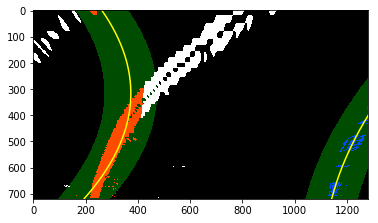

In [124]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

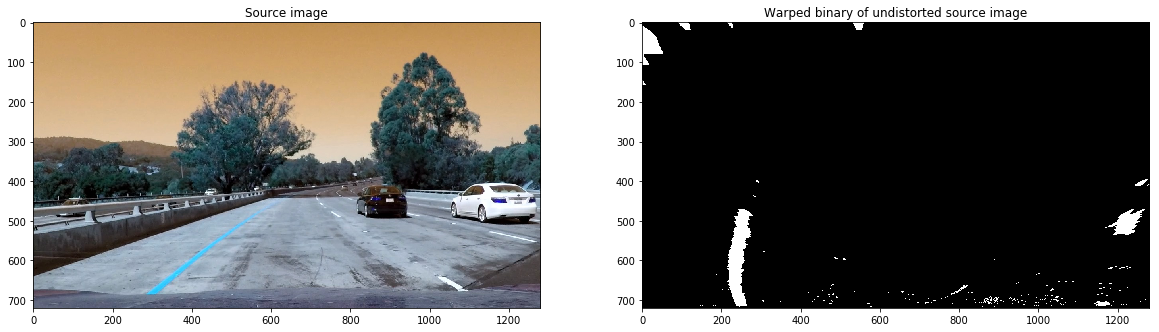

In [126]:
# I feel like this one would work better if we had a mask to exclude that lefternmost non-lane
# Gonna have to build that next...

# 3rd sanity check on this approach:

# Load image
img = cv2.imread('test_images/test1.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

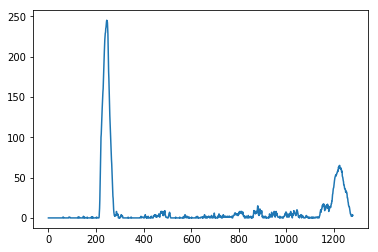

In [127]:
# Create histogram of image binary activations
histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

In [199]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([-1.68313617e-04,  1.27406724e-01, 2.27280430e+02])
right_fit = np.array([2.25490925e-04, -5.95517318e-01, 1.46465623e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    print(ploty.shape, lefty.shape, leftx.shape)
    
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     print (left_fit)
#     print (right_fit)

    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    print(left_fitx.shape)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [197]:
print(left_fitx.shape)

(720,)


(720,) (11783,) (11783,)
(720,)


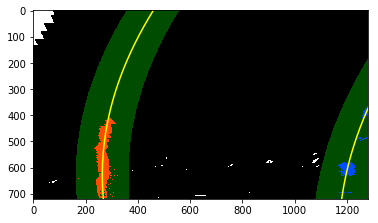

In [200]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

In [ ]:
# Eh, could be worse... I'm feeling good that this will work when turned into a rolling pipeline

# Moving on to determining radius of curvature

In [131]:
# Now we are to measure the radius of curvature of the fit.
# Because our margin search is giving wonky results,
# I'm gonna take a step back and apply it to the output of
# our "less efficient" method from above: out_img

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(out_img)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [132]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

2978.347304112517 3028.121245253715


In [ ]:
# I have no idea if these values are even reasonable,
# much less accurate, lol... But at least it's "working"

# The above function was applied to pixel space
# Now we work with one which is applied to real world values

In [ ]:
# (The grafting process of bringing the offered code over to my notebook
# is more challenging at this point of real-world data, because the Instructors have
# presented it in a form which mimics, but not precisely, the way the
# process worked above. In any case...)

# We start by bringing over the offered text verbatim:

In [158]:
def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    print(ploty.shape, leftx.shape)

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr

In [159]:
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [160]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')

(720,) (720,)
533.7525889210938 m 648.1574851434419 m


In [ ]:
# These results are the expected ones

In [ ]:
# So, we need to replace the generate_data() call with a feed of our actual data

# generate_data() is returning ploty, left_fit_cr, right_fit_cr
# fit_poly(), above, returns left_fitx, right_fitx, ploty

# Thus, generate_data() is doing fit_poly()'s job under a new name
# For comparison's sake:

# def fit_poly(img_shape, leftx, lefty, rightx, righty):
#      ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
#     ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     return left_fitx, right_fitx, ploty

# def generate_data(ym_per_pix, xm_per_pix):
#     '''
#     Generates fake data to use for calculating lane curvature.
#     In your own project, you'll ignore this function and instead
#     feed in the output of your lane detection algorithm to
#     the lane curvature calculation.
#     '''
#     # Set random seed number so results are consistent for grader
#     # Comment this out if you'd like to see results on different random data!
#     np.random.seed(0)
#     # Generate some fake data to represent lane-line pixels
#     ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#     quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
#     # For each y position generate random x position within +/-50 pix
#     # of the line base position in each case (x=200 for left, and x=900 for right)
#     leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                     for y in ploty])
#     rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                     for y in ploty])

#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

#     # Fit a second order polynomial to pixel positions in each fake lane line
#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
#     return ploty, left_fit_cr, right_fit_cr

# The difference between the two being their parameters:
# fit_poly(img_shape, leftx, lefty, rightx, righty)
# generate_data(ym_per_pix, xm_per_pix)

# Thus, we need either to make generate_data() a pass-through function, essentially
# Or update the params that fit_poly() receives to include those passed to generate_data()

# I keep vacillating on my approach...

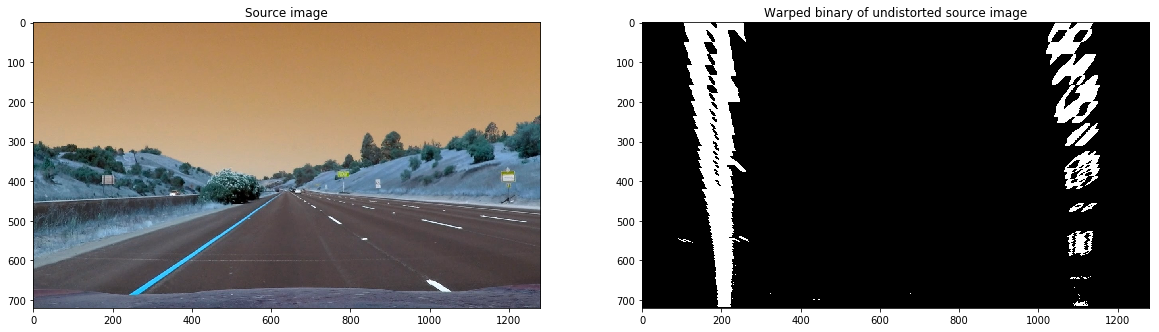

In [210]:
# Load image
img = cv2.imread('test_images/straight_lines1.jpg')
# Correct for camera distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Make a binary of the undistorted image
binary = make_binary(undist)
# Perspective transform the binary
warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(img)
ax2.set_title('Warped binary of undistorted source image')
ax2.imshow(warped, cmap='gray')

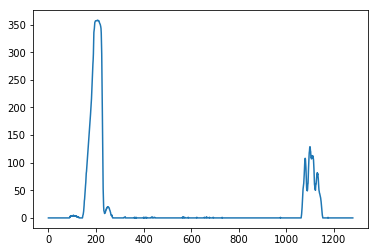

In [211]:
# Create histogram of image binary activations
histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)

2788.080487007827 m 168.27554611005877 m


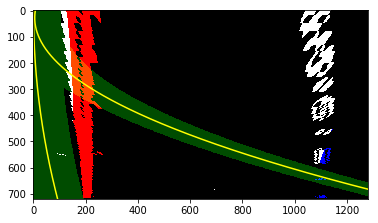

In [227]:
# HYPERPARAMETER
# Choose the width of the margin around the previous polynomial to search
# The quiz grader expects 100 here, but feel free to tune on your own!
margin = 100

# Grab activated pixels
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

### Set the area of search based on activated x-values ###
### within the +/- margin of our polynomial function ###
### Hint: consider the window areas for the similarly named variables ###
### in the previous quiz, but change the windows to our new search area ###
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Grab image shape
img_shape = warped.shape

# Generate x and y values for plotting
ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit a second order polynomial to pixel positions in each lane line
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

### Calc both polynomials using ploty, left_fit_cr and right_fit_cr ###
left_fitx = left_fit_cr[0]*ploty**2 + left_fit_cr[1]*ploty + left_fit_cr[2]
right_fitx = right_fit_cr[0]*ploty**2 + right_fit_cr[1]*ploty + right_fit_cr[2]
    
# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Calculation of R_curve (radius of curvature)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print(left_curverad, 'm', right_curverad, 'm')

## Visualization ##
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
## End visualization steps ##

plt.imshow(result)

In [228]:
left_fit_cr

array([ 1.79360304e-04, -1.01959696e-03,  9.92914102e-01])

In [229]:
ploty

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

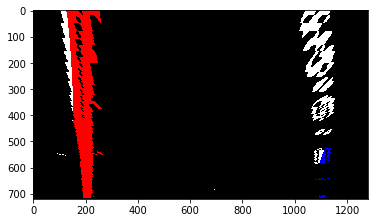

In [230]:
plt.imshow(out_img)

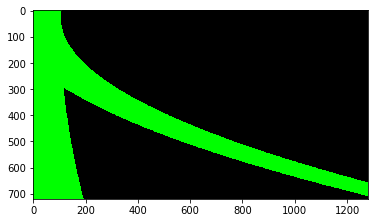

In [231]:
plt.imshow(window_img)

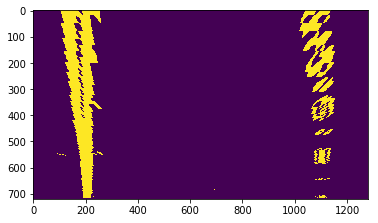

In [232]:
plt.imshow(warped)